## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import sklearn.model_selection as skl

from random import sample 

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from keras.layers import Dense, Dropout, Flatten

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(5)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
57817,00014320_036.png,No Finding,36,14320,26,F,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014320_036.png
26999,00007034_076.png,Fibrosis|Pleural_Thickening|Pneumothorax,76,7034,26,F,AP,3032,2544,0.139,0.139,NaN,/data/images_004/images/00007034_076.png
30009,00007816_011.png,Infiltration,11,7816,67,F,AP,3056,2544,0.139,0.139,NaN,/data/images_004/images/00007816_011.png
48275,00012238_001.png,No Finding,1,12238,63,M,PA,2694,2991,0.143,0.143,NaN,/data/images_006/images/00012238_001.png
106339,00028638_000.png,Atelectasis,0,28638,50,M,PA,3056,2544,0.139,0.139,NaN,/data/images_012/images/00028638_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# split up labels so that I have one column in my dataframe per disease
d = all_xray_df.copy()
all_labels = np.unique(list(chain(*d['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        d[c_label] = d['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
d['Pneumonia_class'] = np.where(d['Pneumonia']==1, "Present", "Not Present")
d = d[d["Patient Age"] < 95]


## Create your training and testing data:

22421
1430
0.25


2013

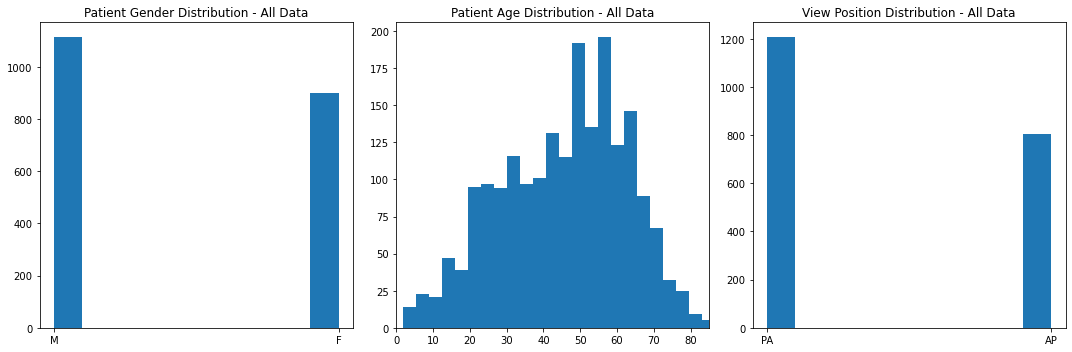

In [5]:
def create_splits(d):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_df, valid_df = skl.train_test_split(d, 
                                   test_size = 0.2, 
                                   stratify = pd.concat([d["Pneumonia"], d["View Position"], d["Patient Gender"]], axis=1))
    
    
    percentAP = len(train_df[train_df["View Position"]=="AP"])/len(train_df)
    

    p_inds = train_df[train_df.Pneumonia==1].index.tolist()
    np_inds = train_df[train_df.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    
    print(len(valid_df))
    
    vp_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
    vnp_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

    vnp_sample = sample(vnp_inds,len(vp_inds)*4)
    valid_df = valid_df.loc[vp_inds + vnp_sample]
    
    print(len(valid_df))
    print(len(valid_df[valid_df.Pneumonia==1])/len(valid_df[valid_df.Pneumonia==0]))
    
    AP_inds = train_df[train_df["View Position"]=="AP"].index.tolist()
    PA_inds = train_df[train_df["View Position"]=="PA"].index.tolist()

    AP_sample = sample(AP_inds,int(len(PA_inds)*(.4/.6)))
    train_df = train_df.loc[PA_inds + AP_sample]
    
    return train_df, valid_df

train_data, val_data = create_splits(d)

val_data['Pneumonia'].sum()/len(val_data)

#make sure other variables (age, sex) are distributied the same as in original data.
fig,a = plt.subplots(1,3, figsize=(15,5))
a = a.ravel()


a[0].hist(train_data["Patient Gender"])
a[0].set_title("Patient Gender Distribution - All Data")

a[1].hist(train_data["Patient Age"], bins=25)
a[1].set_title("Patient Age Distribution - All Data")
a[1].set_xlim([0,85])

a[2].hist(train_data["View Position"])
a[2].set_title("View Position Distribution - All Data")

plt.tight_layout()

#train_data['Pneumonia'].sum()/len(train_data)
#train_data['Pneumonia'].sum()/len(train_data)
#print(val_data['Pneumonia'].sum()/len(val_data))
len(train_data)


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [6]:
IMG_SIZE = (224, 224)

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    
    idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=15, 
                              shear_range = 0.15,
                              zoom_range=0.1)

    
    return idg


def make_train_gen(idg, df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
    train_gen = idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 32
                                         )

    return train_gen


def make_val_gen(idg, df):
    
    val_gen = idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 200
                                         )
    
    # Todo
    return val_gen

idg = my_image_augmentation()
gen = make_train_gen(idg, train_data)


t_x, t_y = next(gen)
'''
fig, m_axs = plt.subplots(3, 3, figsize = (8, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
'''

Found 2013 validated image filenames belonging to 2 classes.


"\nfig, m_axs = plt.subplots(3, 3, figsize = (8, 8))\nfor (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):\n    c_ax.imshow(c_x[:,:,0], cmap = 'bone')\n"

In [7]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = False, 
                              vertical_flip = False, 
                              height_shift_range= 0, 
                              width_shift_range=0, 
                              rotation_range=0, 
                              shear_range = 0,
                              zoom_range=0)

val_gen = make_val_gen(val_idg, val_data)
valX, valY = val_gen.next()
len(valY)

Found 1430 validated image filenames belonging to 2 classes.


200

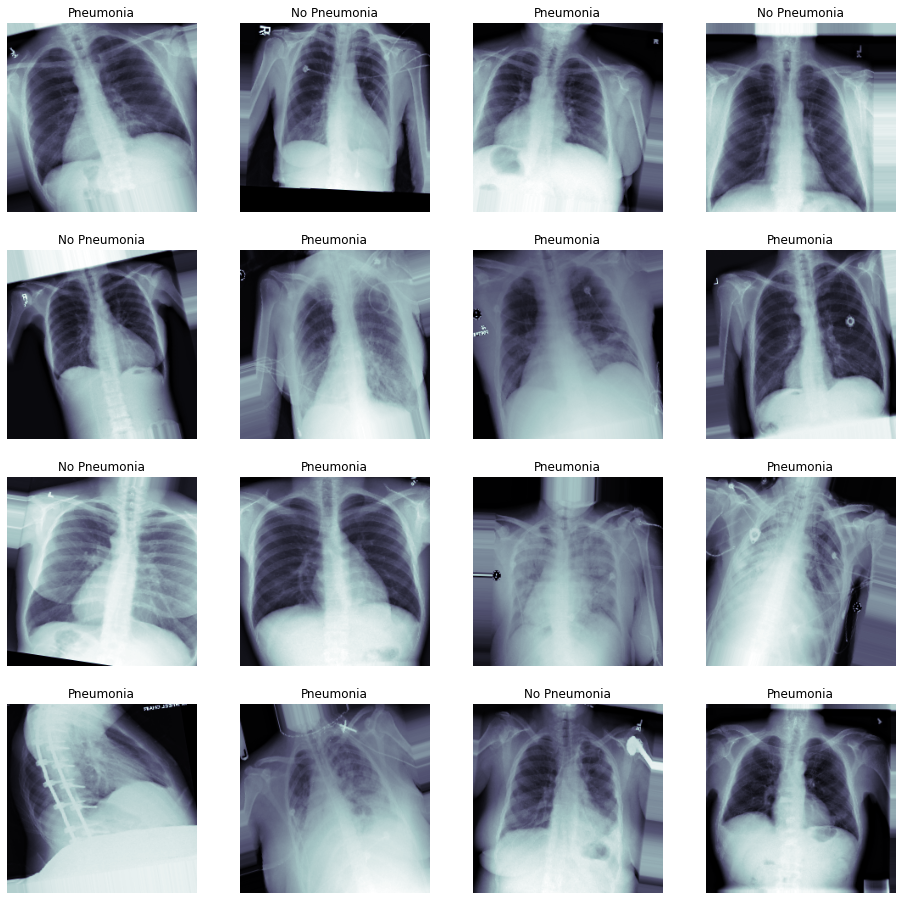

In [8]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:

def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model



In [9]:
def build_my_model(vgg_model):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model.add(vgg_model)
    
    my_model.add(Flatten())
    
    my_model.add(Dropout(0.5))


    my_model.add(Dense(1024, activation='relu'))


    my_model.add(Dropout(0.5))


    my_model.add(Dense(512, activation='relu'))


    my_model.add(Dropout(0.5))


    my_model.add(Dense(256, activation='relu'))

 
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [10]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']


weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= "min", 
                              save_weights_only = True)

early = EarlyStopping(monitor = 'val_loss', 
                       mode= "min", 
                       patience=10)

reduce_lr = ReduceLROnPlateau(monitor = "loss", mode="max", factor=0.8, patience=10, min_lr=1e-5, verbose=1)

callbacks_list = [checkpoint, early, reduce_lr]

### Start training! 

In [13]:
## train your model

# Todo
modle = load_pretrained_model()
new_model = build_my_model(modle)
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
new_model.summary()
#

553467904/553467096 [==============================] - 7s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_____________________________________________________

In [14]:
history = new_model.fit_generator(gen, 
                           validation_data = (valX, valY), 
                           epochs = 100, 
                           callbacks = callbacks_list)

Epoch 1/100
63/63 [==============================] - 65s 1s/step - loss: 0.7968 - binary_accuracy: 0.4988 - val_loss: 0.8009 - val_binary_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 0.80092, saving model to xray_class_my_model.best.hdf5
Epoch 2/100
63/63 [==============================] - 57s 904ms/step - loss: 0.7276 - binary_accuracy: 0.5127 - val_loss: 0.7485 - val_binary_accuracy: 0.2800

Epoch 00002: val_loss improved from 0.80092 to 0.74850, saving model to xray_class_my_model.best.hdf5
Epoch 3/100
63/63 [==============================] - 53s 844ms/step - loss: 0.6973 - binary_accuracy: 0.5375 - val_loss: 0.7116 - val_binary_accuracy: 0.5350

Epoch 00003: val_loss improved from 0.74850 to 0.71162, saving model to xray_class_my_model.best.hdf5
Epoch 4/100
63/63 [==============================] - 53s 840ms/step - loss: 0.6933 - binary_accuracy: 0.5519 - val_loss: 0.7419 - val_binary_accuracy: 0.4650

Epoch 00004: val_loss did not improve from 0.71162
Epoch 5/100
63

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [15]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
new_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 50, verbose = True)
len(pred_Y)

200/200 [==============================] - 7s 34ms/step


200

In [18]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return

def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure(figsize = (12, 12))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

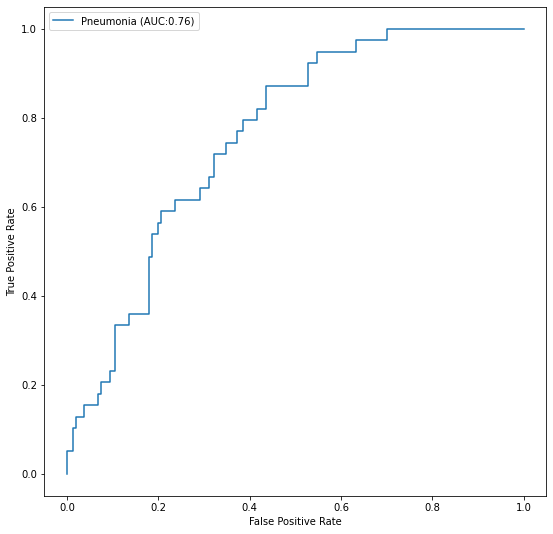

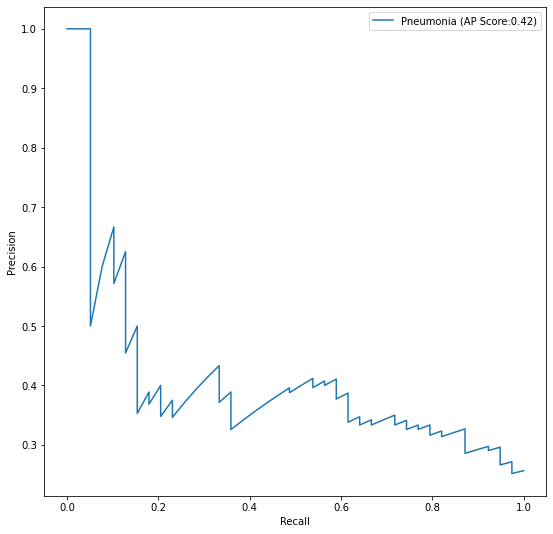

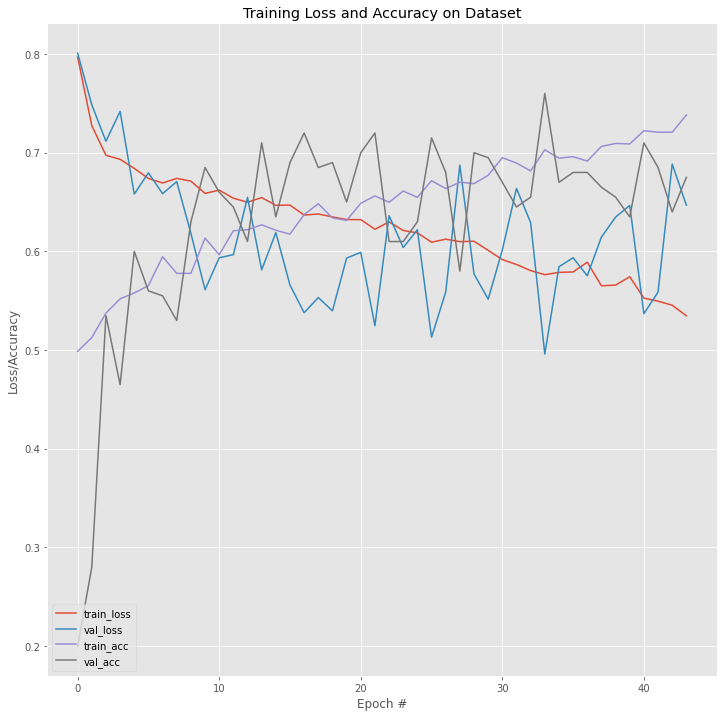

In [19]:
## plot figures

plot_auc(valY, pred_Y)
plot_precision_recall_curve(valY, pred_Y)
plot_history(history)


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

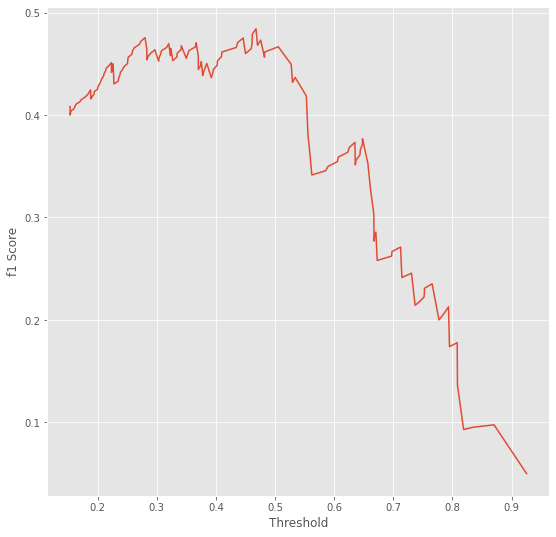

In [20]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
f1s = []

for indx in range(len(thresholds)):
    prec = precision[indx]
    rcall = recall[indx]
    tresh = thresholds[indx]
    f1s.append(calc_f1(prec,rcall))
    
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
c_ax.plot(thresholds, f1s)
c_ax.set_xlabel('Threshold')
c_ax.set_ylabel('f1 Score')

f1s = np.array(f1s[:-5])
best = f1s.argmax()
bestThresh = thresholds[best]
bestF1 = f1s.max()
bestP = precision[best]
bestR = recall[best]

In [21]:

print('Precision is: '+ str(bestP))
print('Recall is: '+ str(bestR))
print('Threshold is: '+ str(bestThresh))
print('F1 Score is: ' + str(bestF1))

Precision is: 0.4107142857142857
Recall is: 0.5897435897435898
Threshold is: 0.467774
F1 Score is: 0.4842105263157895


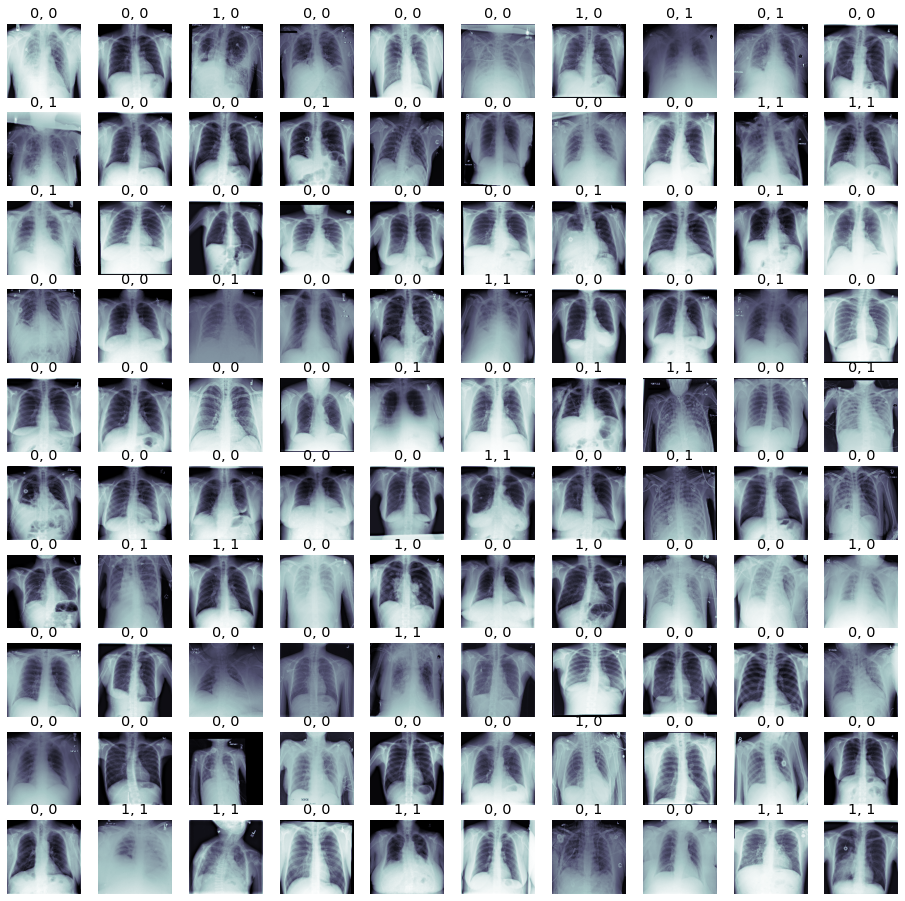

In [22]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > bestF1:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > bestF1: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [23]:
## Just save model architecture to a .json:

model_json = new_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

In [43]:
# try another model
def build_my_model2(vgg_model):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model.add(vgg_model)
    
    my_model.add(Flatten())
    
    my_model.add(Dropout(0.5))


    my_model.add(Dense(1024, activation='relu'))


    my_model.add(Dropout(0.5))


    my_model.add(Dense(512, activation='relu'))


    my_model.add(Dropout(0.5))


    my_model.add(Dense(256, activation='relu'))

 
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [46]:
weight_path="{}_my_model2.best.hdf5".format('xray_class')

optimizer = SGD(lr=1e-4)

checkpoint = ModelCheckpoint(weight_path, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= "min", 
                              save_weights_only = True)

early = EarlyStopping(monitor = 'val_loss', 
                       mode= "min", 
                       patience=10)

reduce_lr = ReduceLROnPlateau(monitor = 'loss', mode="max", factor=0.8, patience=5, min_lr=1e-5, verbose=1)

callbacks_list = [checkpoint, early, reduce_lr]


# Todo
modle2 = load_pretrained_model()
new_model2 = build_my_model2(modle2)
new_model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#

In [47]:
history2 = new_model2.fit_generator(gen, 
                           validation_data = (valX, valY), 
                           epochs = 100, 
                           callbacks = callbacks_list)

Epoch 1/100
62/62 [==============================] - 52s 837ms/step - loss: 0.8491 - binary_accuracy: 0.5102 - val_loss: 0.5494 - val_binary_accuracy: 0.7950

Epoch 00001: val_loss improved from inf to 0.54945, saving model to xray_class_my_model2.best.hdf5
Epoch 2/100
62/62 [==============================] - 50s 813ms/step - loss: 0.8069 - binary_accuracy: 0.4944 - val_loss: 0.5281 - val_binary_accuracy: 0.7950

Epoch 00002: val_loss improved from 0.54945 to 0.52810, saving model to xray_class_my_model2.best.hdf5
Epoch 3/100
62/62 [==============================] - 50s 800ms/step - loss: 0.7883 - binary_accuracy: 0.5061 - val_loss: 0.5222 - val_binary_accuracy: 0.7950

Epoch 00003: val_loss improved from 0.52810 to 0.52215, saving model to xray_class_my_model2.best.hdf5
Epoch 4/100
62/62 [==============================] - 50s 802ms/step - loss: 0.7734 - binary_accuracy: 0.5142 - val_loss: 0.5210 - val_binary_accuracy: 0.7950

Epoch 00004: val_loss improved from 0.52215 to 0.52096, sav

In [48]:
# try another model
def build_my_model3(vgg_model):
    
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model.add(vgg_model)
    
    my_model.add(Flatten())
    
    my_model.add(Dropout(0.5))


    my_model.add(Dense(1024, activation='relu'))


    my_model.add(Dropout(0.3))


    my_model.add(Dense(512, activation='relu'))


    my_model.add(Dropout(0.1))


    my_model.add(Dense(256, activation='relu'))

 
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [49]:
weight_path="{}_my_model3.best.hdf5".format('xray_class')

optimizer = SGD(lr=1e-4)

checkpoint = ModelCheckpoint(weight_path, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= "min", 
                              save_weights_only = True)

early = EarlyStopping(monitor = 'val_loss', 
                       mode= "min", 
                       patience=10)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=7, min_lr=1e-5, verbose=1)

callbacks_list = [checkpoint, early, reduce_lr]


# Todo
modle3 = load_pretrained_model()
new_model3 = build_my_model3(modle3)
new_model3.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#

In [50]:
history3 = new_model3.fit_generator(gen, 
                           validation_data = (valX, valY), 
                           epochs = 100, 
                           callbacks = callbacks_list)

Epoch 1/100
62/62 [==============================] - 50s 810ms/step - loss: 0.8239 - binary_accuracy: 0.5178 - val_loss: 0.8686 - val_binary_accuracy: 0.2050

Epoch 00001: val_loss improved from inf to 0.86858, saving model to xray_class_my_model3.best.hdf5
Epoch 2/100
62/62 [==============================] - 48s 768ms/step - loss: 0.7268 - binary_accuracy: 0.5112 - val_loss: 0.9511 - val_binary_accuracy: 0.2050

Epoch 00002: val_loss did not improve from 0.86858
Epoch 3/100
62/62 [==============================] - 48s 771ms/step - loss: 0.7360 - binary_accuracy: 0.4980 - val_loss: 0.9961 - val_binary_accuracy: 0.2050

Epoch 00003: val_loss did not improve from 0.86858
Epoch 4/100
62/62 [==============================] - 48s 779ms/step - loss: 0.7296 - binary_accuracy: 0.5025 - val_loss: 0.9464 - val_binary_accuracy: 0.2050

Epoch 00004: val_loss did not improve from 0.86858
Epoch 5/100
62/62 [==============================] - 50s 799ms/step - loss: 0.7256 - binary_accuracy: 0.5010 - v

200/200 [==============================] - 2s 10ms/step


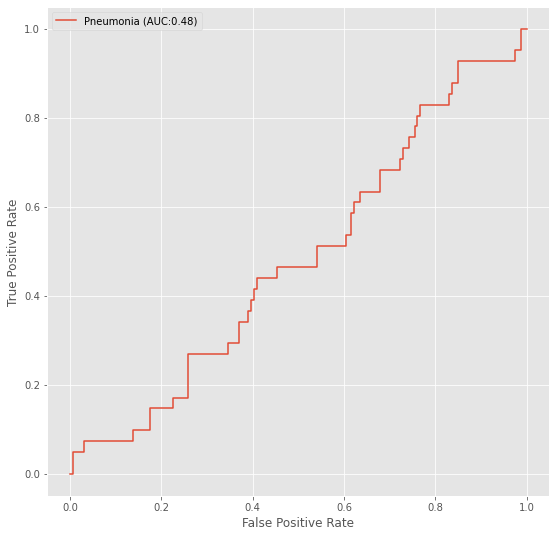

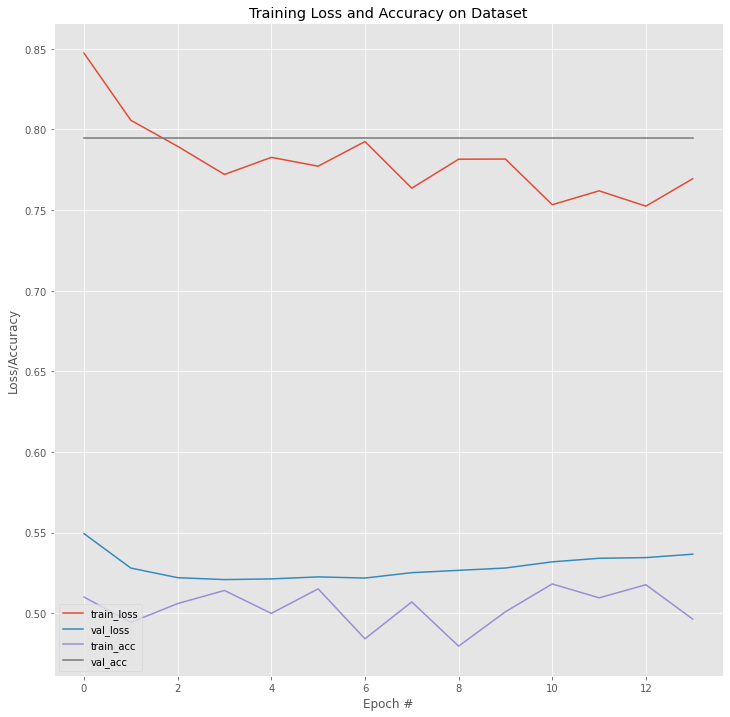

In [64]:
weight_path="{}_my_model2.best.hdf5".format('xray_class')

new_model2.load_weights(weight_path)
pred_Y = new_model2.predict(valX, batch_size = 64, verbose = True)

plot_auc(valY, pred_Y)
#plot_precision_recall_curve(valY, pred_Y)
plot_history(history2)